# Exploring the Dry Tortugas Sr/Ca data

## Authors

[Deborah Khider](https://orcid.org/0000-0001-7501-8430)

## Preamble

A common exercise in paleoclimatology is the calibration of the measured proxy (in this case, coral Sr/Ca) to the environmental parameter that controls it (sea surface temperature). This notebook walks through data exploration of the Sr/Ca measurments made on various coral in Dry Tortugas compared to instrumental data. Some figures are reproduced from the original study by [DeLong et al. 2011](https://www.sciencedirect.com/science/article/pii/S0031018211002501?casa_token=u1x_ZYnm_mIAAAAA:rU7n-8jHh2g5UPgGHs5h1iptBXVa6rfvKFxpOwgMjHgB6g4jUZ9oRppzJz7O5UQHDlc1U3xhYSg). 

Let's import the necessary packages:

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pyleoclim as pyleo

## Data Description

The data are available through the database maintained by [NOAA NCEI](https://www.ncei.noaa.gov/access/paleo-search/study/11935) in `.txt` and `.xls` format. Let's import them into the workspace using `pandas`:

In [4]:
url = 'https://www.ncei.noaa.gov/pub/data/paleo/coral/atlantic/tortugas2011.xls'
df = pd.read_excel(url, sheet_name=1,header=[0,1,2])
df.head()

Coral    Siderastrea sidera                                      \
          Core                  A1-A                                       
          Year Mean Sr/Ca (mmol/mol) Number of samples St. error of mean   
0  2008.625000              8.737095                 1          0.012000   
1  2008.541667              8.770223                 2          0.003228   
2  2008.458333              8.841024                 2          0.003956   
3  2008.375000              8.940933                 2          0.001614   
4  2008.291667              9.022715                 2          0.003125   

                                                             \
                   F1-A                                       
  Mean Sr/Ca (mmol/mol) Number of samples St. error of mean   
0                   NaN               NaN               NaN   
1                   NaN               NaN               NaN   
2                   NaN               NaN               NaN   
3              8.972382               1.0              0.01   
4              9.062088               1.0              0.01   

  Montastraea faveolata                                      \
                   B3-A                                       
  Mean Sr/Ca (mmol/mol) Number of samples St. error of mean   
0              9.025385                 3          0.003027   
1              9.051444                 3          0.010060   
2              9.111843                 3          0.000554   
3              9.190204                 3          0.021459   
4              9.232626                 3          0.010278   

  Monthly mean SST from NDBC www.ndbc.noaa.gov                    \
                               DRYF1 and PLSF1                     
                                 DRTO SST (ºC) St. error of mean   
0                                    30.193011          0.010330   
1                                    29.551197          0.010570   
2                                    28.539499          0.022829   
3                                    26.642473          0.026493   
4                                    24.905000          0.019899   

                                       
              SANF1                    
  Sand Key SST (ºC) St. error of mean  
0               NaN               NaN  
1               NaN               NaN  
2               NaN               NaN  
3               NaN               NaN  
4               NaN               NaN

The file contains the following information:
- `Year`: Time axis
- `Mean Sr/Ca (mmol/mol)`: the measured Sr/Ca values for *Siderastrea sidera* core A1-A (column 2), core F1-A (column 5), and for *Montastraea faveolata* core B3-A (column 8)
- `Number of samples`: Number of measured samples for *Siderastrea sidera* core A1-A (column 3), core F1-A (column 6), and for *Montastraea faveolata* core B3-A (column 9)
- `St. error of mean` (columns 4,7,10): The standard error associated with the measurements for for *Siderastrea sidera* core A1-A (column 4), core F1-A (column 7), and for *Montastraea faveolata* core B3-A (column 10)
- `DRTO SST (°C)` column 11): Instrumental sea surface temperature (°C) from two stations in the National Data Buoy Center database close to the location of the coral records.
- `St. error of mean` (column 12): Standard error on the DRTO instrumental record.
- `Sand Key SST (°C)` (column 13): Instrumental sea surface temperature (°C) from a station in the National Data Buoy Center database located on a coral reef at Sand Key. The Sand Key record was used to augment the number of data points compared to the DRTO record. 
- `St. error of mean` (column 14): Standard error on the Sand Key instrumental record.
 
## Coral Sr/Ca
let's plot the data, leveraging `pandas` indexing (`iloc`) to access what we want:

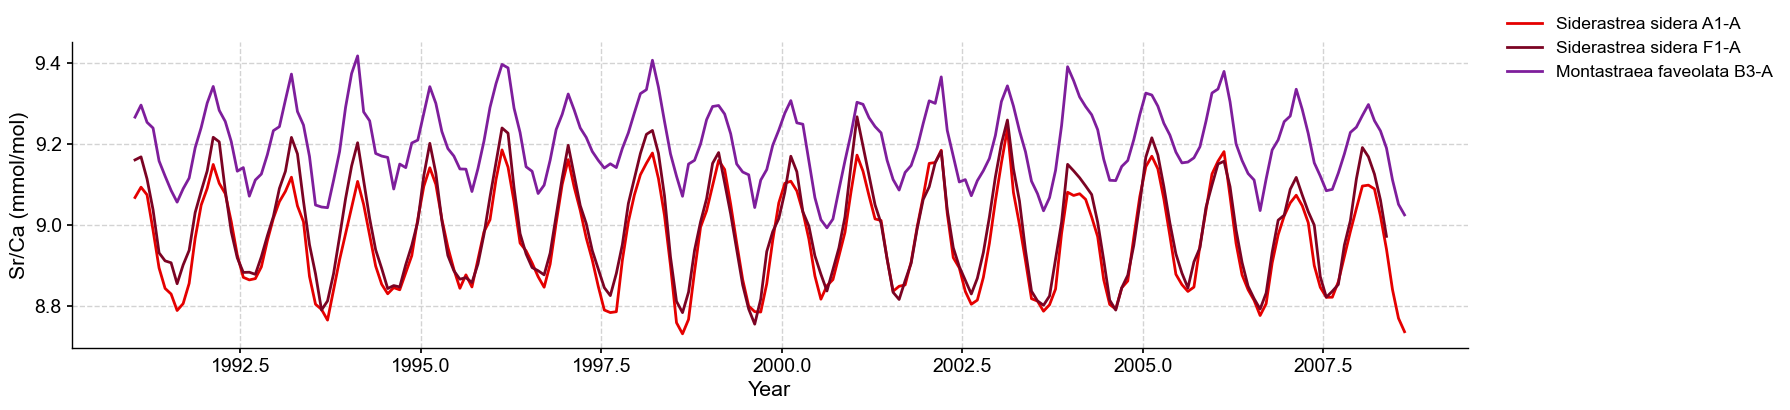

In [5]:
fig,ax1 = plt.subplots(figsize=(15,4))
ax1.plot(df.iloc[:,0], df.iloc[:,1], label = "Siderastrea sidera A1-A", color = sns.xkcd_rgb['red'])
ax1.plot(df.iloc[:,0], df.iloc[:,4], label = "Siderastrea sidera F1-A", color = sns.xkcd_rgb['wine red'])
ax1.plot(df.iloc[:,0], df.iloc[:,7], label = "Montastraea faveolata B3-A", color = sns.xkcd_rgb['purple'])
ax1.set_xlabel('Year')
ax1.set_ylabel('Sr/Ca (mmol/mol)')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

There seems to be an offset between the two species, which will require separate calibation. This offset was observed in the original study and attributed to sampling effects.

## Instrumental Sea Surface Temperature

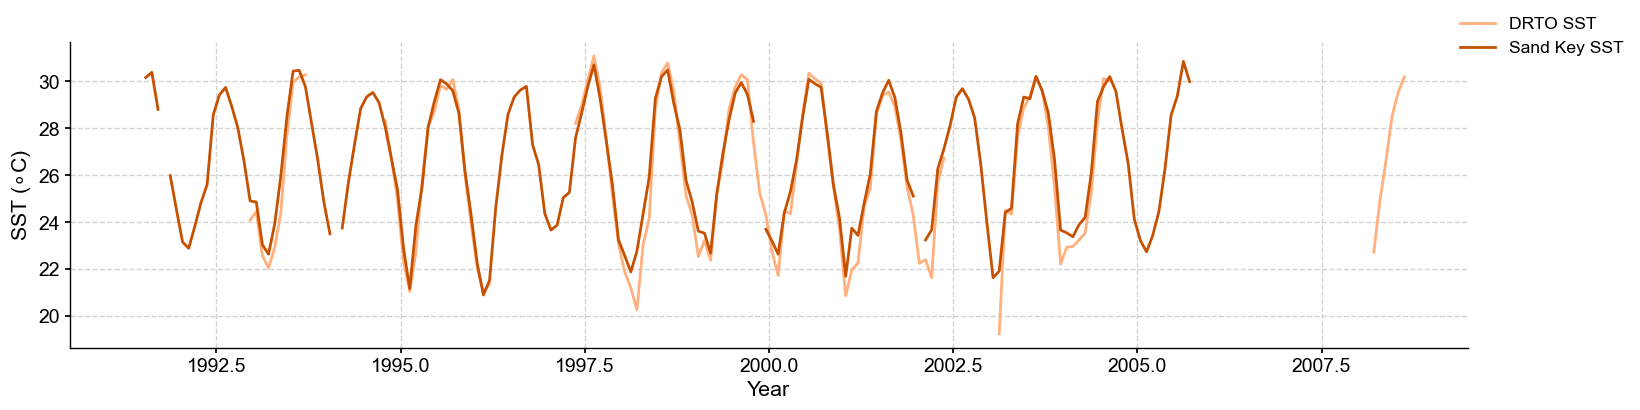

In [6]:
fig,ax2 = plt.subplots(figsize=(15,4))

ax2.plot(df.iloc[:,0],df.iloc[:,10], label = 'DRTO SST', color = sns.xkcd_rgb['peach'])
ax2.plot(df.iloc[:,0],df.iloc[:,12], label = 'Sand Key SST', color = sns.xkcd_rgb['dark orange'])
ax2.set_ylabel('SST ($\circ$C)')
ax2.set_xlabel('Year')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

There is a remarkable agreement between the instrumental datasets from the two locations. 

## Sr/Ca vs Sea Surface Temperature

### A timeseries view: *Siderastrea sidera*

Let's have a look at each coral species vs temperature, inverting the Sr/Ca axis to highlight the negative relationship between the two. We will start with *Siderastrea sidera*:

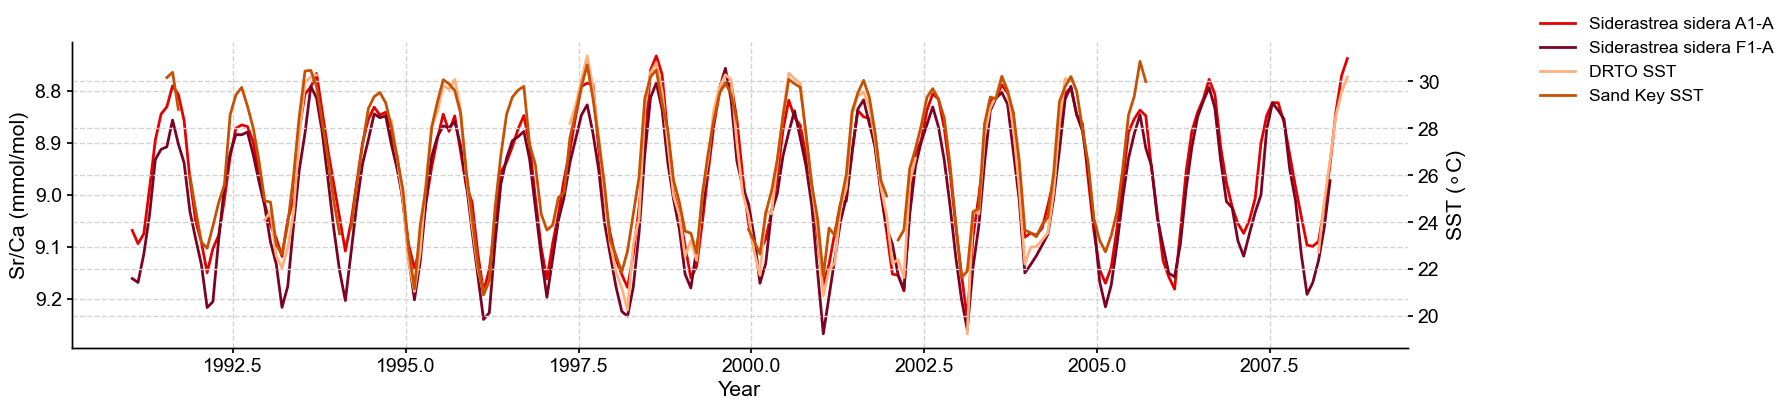

In [7]:
fig,ax1 = plt.subplots(figsize=(15,4))
ax1.plot(df.iloc[:,0], df.iloc[:,1], label = "Siderastrea sidera A1-A", color = sns.xkcd_rgb['red'])
ax1.plot(df.iloc[:,0], df.iloc[:,4], label = "Siderastrea sidera F1-A", color = sns.xkcd_rgb['wine red'])
ax1.set_xlabel('Year')
ax1.set_ylabel('Sr/Ca (mmol/mol)')
ax1.invert_yaxis()

ax2=ax1.twinx()
ax2.plot(df.iloc[:,0],df.iloc[:,10], label = 'DRTO SST', color = sns.xkcd_rgb['peach'])
ax2.plot(df.iloc[:,0],df.iloc[:,12], label = 'Sand Key SST', color = sns.xkcd_rgb['dark orange'])
ax2.set_ylabel('SST ($\circ$C)')
ax2.spines['right']

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

Let's calculate the correlation between coral Sr/Ca and SST using the [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/) package. First, let's create [`Series`](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series) objects for each of the coral and instrumental records:

In [8]:
A1A = pyleo.Series(time=df.iloc[:,0], value= df.iloc[:,1], time_name = 'Year', time_unit = 'CE', value_name = 'Sr/Ca', value_unit = 'mmmol/mol', label = 'Siderastrea sidera A1-A', verbose = False)
F1A = pyleo.Series(time=df.iloc[:,0], value= df.iloc[:,4], time_name = 'Year', time_unit = 'CE', value_name = 'Sr/Ca', value_unit = 'mmmol/mol', label = 'Siderastrea sidera F1-A', verbose = False)
DRTO = pyleo.Series(time=df.iloc[:,0], value= df.iloc[:,10], time_name = 'Year', time_unit = 'CE', value_name = 'SST', value_unit = '$\circ$C', label = 'DRTO', verbose = False)
SK = pyleo.Series(time=df.iloc[:,0], value= df.iloc[:,12], time_name = 'Year', time_unit = 'CE', value_name = 'SST', value_unit = '$\circ$C', label = 'Sand Key', verbose = False)

Let's create a [`MultipleSeries`](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.multipleseries.MultipleSeries) object so we can take advantage of the time axis alignment capabilities.

In [9]:
ms = pyleo.MultipleSeries([A1A,F1A,DRTO,SK])

Let's get all these Series on a common time axis so we can make meaningful comparisons among the correlations:

In [10]:
ms_interp = ms.common_time()

#### Correlation between *Siderastrea sidera* and SST

Now we can compute the correlation (as expressed by Pearson's product-moment correlation, or as more commonly known, [Pearson's R](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)) between the coral records and instrumental datasets. Given the autocorrelation in the two timeseries introduced by the seasonal cycle, we need to be able to assess the significance of this correlation. Here we will use phase-randomized surrogates, the default method in [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.correlation). Let's start with core A1A and DRTO:

In [11]:
corr = ms_interp.series_list[0].standardize().correlation(ms_interp.series_list[2].standardize())
print('The correlation between Siderastrea sidera core A1A and DRTO instrumental temperature is:')
print(corr)

Evaluating association on surrogate pairs: 100%|█| 1000/1000 [00:00<00:00, 3296.

The correlation between Siderastrea sidera core A1A and DRTO instrumental temperature is:
  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
    -0.710412  < 1e-6     True



Not surprinsgly, we find a strong and significant anti-correlation between the coral Sr/Ca and SST. Let's check with the Sand Key instrumental record:

In [12]:
corr = ms_interp.series_list[0].standardize().correlation(ms_interp.series_list[3].standardize())
print('The correlation between Siderastrea sidera core A1A and Sand Key instrumental temperature is:')
print(corr)

Evaluating association on surrogate pairs: 100%|█| 1000/1000 [00:00<00:00, 3641.

The correlation between Siderastrea sidera core A1A and Sand Key instrumental temperature is:
  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     -0.96559  < 1e-6     True



The anticorrelation is even stronger between coral Sr/Ca and Sand Key, which is not surprising given the gaps in the DRTO data that were filled with a simple interpolation.

Let's repeat the analysis for core F1A:

In [13]:
corr = ms_interp.series_list[1].standardize().correlation(ms_interp.series_list[2].standardize())
print('The correlation between Siderastrea sidera core F1A and DRTO instrumental temperature is:')
print(corr)

corr = ms_interp.series_list[1].standardize().correlation(ms_interp.series_list[3].standardize())
print('The correlation between Siderastrea sidera core F1A and Sand Key instrumental temperature is:')
print(corr)

Evaluating association on surrogate pairs: 100%|█| 1000/1000 [00:00<00:00, 3917.


The correlation between Siderastrea sidera core F1A and DRTO instrumental temperature is:
  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
    -0.705579  < 1e-6     True



Evaluating association on surrogate pairs: 100%|█| 1000/1000 [00:00<00:00, 3818.

The correlation between Siderastrea sidera core F1A and Sand Key instrumental temperature is:
  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
    -0.968178  < 1e-6     True



The results are very similar between the two cores. 

### A timeseries view: *Montastraea faveolata*

Let's do the same with *Montastraea faveolata B3-A*:

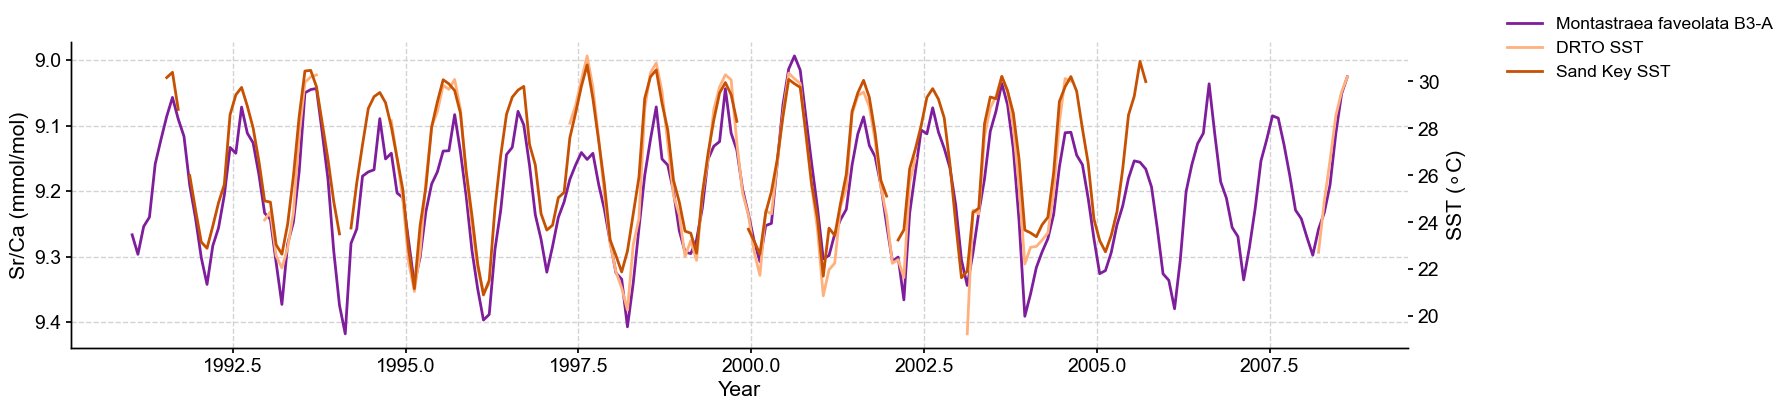

In [14]:
fig,ax1 = plt.subplots(figsize=(15,4))
ax1.plot(df.iloc[:,0], df.iloc[:,7], label = "Montastraea faveolata B3-A", color = sns.xkcd_rgb['purple'])
ax1.set_xlabel('Year')
ax1.set_ylabel('Sr/Ca (mmol/mol)')
ax1.invert_yaxis()
ax2=ax1.twinx()
ax2.plot(df.iloc[:,0],df.iloc[:,10], label = 'DRTO SST', color = sns.xkcd_rgb['peach'])
ax2.plot(df.iloc[:,0],df.iloc[:,12], label = 'Sand Key SST', color = sns.xkcd_rgb['dark orange'])
ax2.set_ylabel('SST ($\circ$C)')
plt.grid(False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

#### Correlation between *Montastraea faveolata* and SST

In [15]:
B3A = pyleo.Series(time=df.iloc[:,0], value= df.iloc[:,7], time_name = 'Year', time_unit = 'CE', value_name = 'Sr/Ca', value_unit = 'mmmol/mol', label = 'Montastraea faveolata B3-A', verbose = False)

ms_mf = pyleo.MultipleSeries([B3A,DRTO,SK])

Let's place these series on a common time axis:

In [16]:
ms_mf_interp = ms_mf.common_time()

And let's take the correlations!

In [17]:
corr = ms_mf_interp.series_list[0].standardize().correlation(ms_mf_interp.series_list[1].standardize())
print('The correlation between Montastraea faveolata core B3A and DRTO instrumental temperature is:')
print(corr)

corr = ms_mf_interp.series_list[0].standardize().correlation(ms_mf_interp.series_list[2].standardize())
print('The correlation between Montastraea faveolata core B3A and Sand Key instrumental temperature is:')
print(corr)

Evaluating association on surrogate pairs: 100%|█| 1000/1000 [00:00<00:00, 3768.


The correlation between Montastraea faveolata core B3A and DRTO instrumental temperature is:
  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
    -0.622494       0.03  True



Evaluating association on surrogate pairs: 100%|█| 1000/1000 [00:00<00:00, 3854.

The correlation between Montastraea faveolata core B3A and Sand Key instrumental temperature is:
  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
    -0.923575  < 1e-6     True



We observe the same strength of the anticorrelation.

## A scatter plot view

A more straighforward way to visualize this dataset is to plot Sr/Ca vs SST as in Figure 7 of the original manuscript. The figure also contains a panel showing seasonal variations in Sr/Ca and SST. Let's start by pulling the data for this part of the figure: 

In [18]:
def round_to_significant(x, significant_digits=3):
    # Shift the number so the significant part is left of the decimal point
    shift = significant_digits - 1 - math.floor(math.log10(abs(x)))
    factor = 10 ** shift
        # Round the number at the shifted position and shift back
    return round(x * factor) / factor

df_strip = pd.read_excel(url, sheet_name=1,header=[2])
df_strip['Year_Dec'] = df_strip['Year'].apply(lambda x: round_to_significant(x % 1, 3) if isinstance(x, (int, float)) else x)
grouped_df = df_strip.groupby('Year_Dec').mean()
grouped_df

,Year,Mean Sr/Ca (mmol/mol),Number of samples,St. error of mean,Mean Sr/Ca (mmol/mol).1,Number of samples.1,St. error of mean.1,Mean Sr/Ca (mmol/mol).2,Number of samples.2,St. error of mean.2,DRTO SST (ºC),St. error of mean.3,Sand Key SST (ºC),St. error of mean.4
Year_Dec,,,,,,,,,,,,,,
0.0417,1999.541667,9.109034,2.111111,0.008934,9.150712,1.333333,0.009633,9.305624,2.500000,0.015127,22.451185,0.028995,23.062052,0.034643
0.1250,1999.625000,9.133615,2.111111,0.010182,9.180347,1.277778,0.009690,9.328770,2.444444,0.017359,21.739958,0.026452,22.692976,0.036881
0.2080,1999.708333,9.098765,2.166667,0.012220,9.140562,1.277778,0.009979,9.300653,2.611111,0.016524,22.517117,0.032490,23.528907,0.040111
0.2920,1999.791667,9.024714,2.111111,0.013141,9.059087,1.277778,0.010395,9.248827,2.722222,0.015633,24.438476,0.027952,24.931675,0.027108
0.3750,1999.875000,8.948943,2.111111,0.009085,8.974847,1.277778,0.011020,9.194245,2.722222,0.015871,26.341956,0.032119,26.821058,0.031313
0.4580,1999.958333,8.873235,2.111111,0.006919,8.900051,1.352941,0.010505,9.140231,2.722222,0.014527,28.597185,0.026130,28.740994,0.024248
0.5420,2000.041667,8.822578,2.111111,0.007958,8.850342,1.352941,0.010950,9.107287,2.722222,0.015620,29.877780,0.017445,29.708116,0.019679
0.6250,2000.125000,8.811292,2.055556,0.010360,8.826928,1.352941,0.011434,9.074950,2.666667,0.017475,30.208851,0.014917,30.115725,0.023875
0.7080,1999.708333,8.824181,2.117647,0.009765,8.858771,1.352941,0.013244,9.109323,2.588235,0.015410,29.727717,0.017995,29.419857,0.023371


Now that we have all the data, let's create our plot!

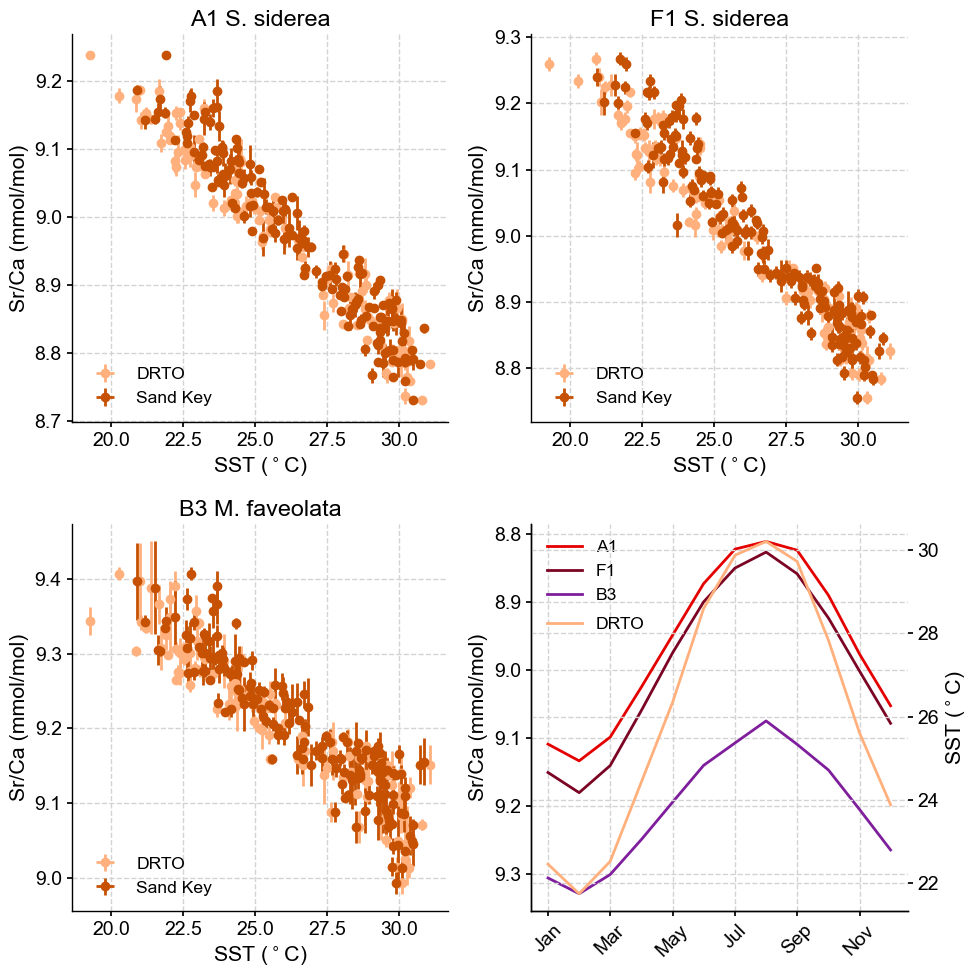

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

#Plotting A1 S. siderea
axs[0,0].errorbar(df.iloc[:,10],df.iloc[:,1], xerr = df.iloc[:,11], yerr = df.iloc[:,3], marker= 'o', color = sns.xkcd_rgb['peach'], linestyle='None', label = 'DRTO')
axs[0,0].errorbar(df.iloc[:,12],df.iloc[:,1], xerr = df.iloc[:,13], yerr = df.iloc[:,3], marker= 'o', color = sns.xkcd_rgb['dark orange'], linestyle='None', label = 'Sand Key')
axs[0,0].set_title('A1 S. siderea')
axs[0,0].set_xlabel('SST ($^\circ$C)')
axs[0,0].set_ylabel('Sr/Ca (mmol/mol)')
axs[0,0].legend(loc= 'lower left')

#Plotting F1 S. siderea
axs[0,1].errorbar(df.iloc[:,10],df.iloc[:,4], xerr = df.iloc[:,11], yerr = df.iloc[:,6], marker= 'o', color = sns.xkcd_rgb['peach'], linestyle='None', label = 'DRTO')
axs[0,1].errorbar(df.iloc[:,12],df.iloc[:,4], xerr = df.iloc[:,13], yerr = df.iloc[:,6], marker= 'o', color = sns.xkcd_rgb['dark orange'], linestyle='None', label = 'Sand Key')
axs[0,1].set_title('F1 S. siderea')
axs[0,1].set_xlabel('SST ($^\circ$C)')
axs[0,1].set_ylabel('Sr/Ca (mmol/mol)')
axs[0,1].legend(loc= 'lower left')

#Plotting B3 M. faveolata
axs[1,0].errorbar(df.iloc[:,10],df.iloc[:,7], xerr = df.iloc[:,11], yerr = df.iloc[:,9], marker= 'o', color = sns.xkcd_rgb['peach'], linestyle='None', label = 'DRTO')
axs[1,0].errorbar(df.iloc[:,12],df.iloc[:,7], xerr = df.iloc[:,13], yerr = df.iloc[:,9], marker= 'o', color = sns.xkcd_rgb['dark orange'], linestyle='None', label = 'Sand Key')
axs[1,0].set_title('B3 M. faveolata')
axs[1,0].set_xlabel('SST ($^\circ$C)')
axs[1,0].set_ylabel('Sr/Ca (mmol/mol)')
axs[1,0].legend(loc= 'lower left')

#Plotting seasonal cycle
axs[1,1].plot(grouped_df.iloc[:,1], color = sns.xkcd_rgb['red'], label='A1')
axs[1,1].plot(grouped_df.iloc[:,4], color = sns.xkcd_rgb['wine red'], label='F1')
axs[1,1].plot(grouped_df.iloc[:,7], color = sns.xkcd_rgb['purple'], label='B3')
axs[1,1].set_ylim(axs[1, 1].get_ylim()[::-1])
axs[1, 1].legend(loc='upper left')
axs[1,1].set_ylabel('Sr/Ca (mmol/mol)')
axs[1,1].set_xticks(ticks=grouped_df.index.to_list()[0::2], labels=['Jan','Mar','May','Jul','Sep','Nov'], rotation=45)

ax2 = axs[1, 1].twinx()
ax2.plot(grouped_df.iloc[:,10], color = sns.xkcd_rgb['peach'], label='DRTO')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.8))
ax2.set_ylabel('SST ($^\circ$C)')

# Adjust layout to prevent overlap
plt.tight_layout()

Given the strong relationship between coral Sr/Ca and SST at this location, the next logical step is to calibrate this paleothermomter. First, we will use a [frequentist approach](FrequentistCalibration.ipynb).

## References

DeLong, K.L., J.A. Flannery, C.R. Maupin, R.Z. Poore, and T.M. Quinn. 2011. A coral Sr/Ca calibration and replication study of two massive corals from the Gulf of Mexico. Palaeogeography, Palaeoclimatology, Palaeoecology, 307(1-4), 117-128. doi: 10.1016/j.palaeo.2011.05.005